In [189]:
import pandas as pd
import yfinance as yf
import numpy as np
np.random.seed(0)
from arch import arch_model
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# Options Data Extraction

In [38]:
def fetch_options_data(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)

    call = pd.DataFrame()
    put = pd.DataFrame()
    for dates in ticker.options:
        options_data = ticker.option_chain(dates)
        call = pd.concat([call, options_data.calls], axis=0)
        put = pd.concat([put, options_data.puts], axis=0)

    return call.reset_index(drop=True), put.reset_index(drop=True)


aapl_calls, aapl_puts = fetch_options_data('AAPL')
aapl_calls.to_csv('aapl_calls.csv')
aapl_puts.to_csv('aapl_puts.csv')

# 1.2 Non-constant Volatility Model: GARCH Model

We have selected the GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to capture the non-constant volatility characteristics of the historical data, where we continue our analysis by using the logarithmic price difference as the yield metric. We used the GARCH(1,1) model to fit the log returns data, which is effective at capturing volatility clustering.

In [190]:
data = pd.read_csv('AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])

data = data.rename(columns={'AAPL': 'price'})
data['log_return'] = np.log(data['price']/data['price'].shift(1)).dropna()
data['log_return'] = data['log_return'] / np.sqrt(1/252)
garch_model = arch_model(data['log_return'].dropna(), vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

data['garch_volatility'] =(garch_result.conditional_volatility)
print(garch_result.summary())
data

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -63.6498
Distribution:                  Normal   AIC:                           135.300
Method:            Maximum Likelihood   BIC:                           153.801
                                        No. Observations:                  754
Date:                Sat, Nov 02 2024   Df Residuals:                      753
Time:                        16:22:31   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0137  9.340e-03      1.462      0.144 

D:\conda\envs\python311\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07569. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


,Date,price,log_return,garch_volatility
0,2021-11-01 00:00:00+00:00,146.506653,NaN,NaN
1,2021-11-02 00:00:00+00:00,147.549210,0.112565,0.236085
2,2021-11-03 00:00:00+00:00,148.994980,0.154790,0.233301
3,2021-11-04 00:00:00+00:00,148.473740,-0.055632,0.231337
4,2021-11-05 00:00:00+00:00,149.005600,0.056764,0.228354
...,...,...,...,...
750,2024-10-25 00:00:00+00:00,231.410004,0.057728,0.229723
751,2024-10-28 00:00:00+00:00,233.399994,0.135928,0.226585
752,2024-10-29 00:00:00+00:00,233.669998,0.018354,0.224505
753,2024-10-30 00:00:00+00:00,230.100006,-0.244401,0.221390


TODO as follows

## (a) Log returns

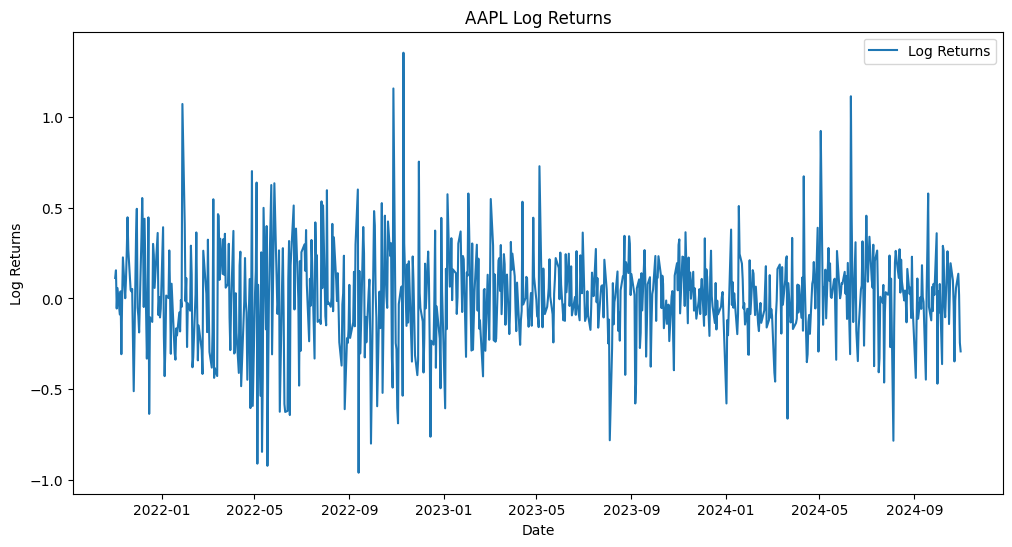

In [191]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['log_return'], label='Log Returns')
plt.title('AAPL Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()

TODO

## (b) Estimated Price

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(data=GARCH_simulated, ax=ax)
ax.set(xlabel='time', ylabel='stock price')

TODO

## (c) Estimated Volatility

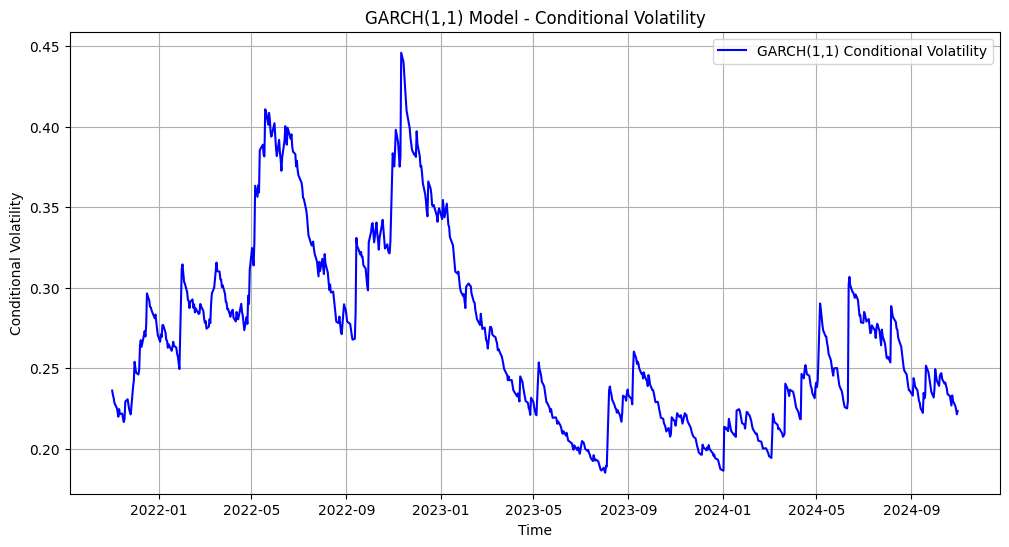

In [192]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['garch_volatility'], color='blue', label='GARCH(1,1) Conditional Volatility')
plt.xlabel('Time')
plt.ylabel('Conditional Volatility')
plt.title('GARCH(1,1) Model - Conditional Volatility')
plt.legend()
plt.grid(True)
plt.show()

TODO

# 1.3 Volatility Smile

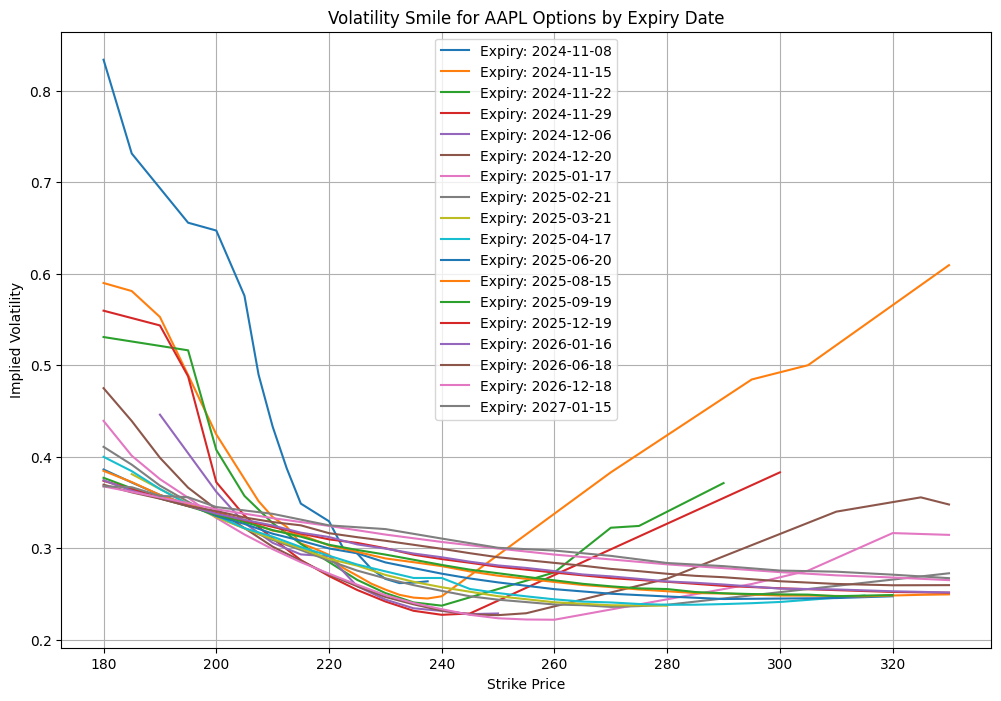

In [193]:
aapl_calls = pd.read_csv('aapl_calls.csv')
aapl_puts = pd.read_csv('aapl_puts.csv')
spot_price = 222.91 # 2024-11-01

# Take call option as example
options_data = aapl_calls


# Extract Expiry
options_data['expiry'] = options_data['contractSymbol'].str[4:10]
options_data['expiry'] = pd.to_datetime('20' + options_data['expiry'], format='%Y%m%d')


# Calculate TTM & Moneyness
options_data['TTM'] = (options_data['expiry'] - pd.to_datetime('2024-11-01')).dt.days / 365
options_data['Moneyness'] = options_data['strike'] / spot_price


# The data needs to be cleaned
#options_data = options_data[options_data['expiry'] <= pd.to_datetime('2025-03-21')]
options_data = options_data[(options_data['impliedVolatility']> 0.1) & (options_data['impliedVolatility']< 1)]
options_data = options_data[options_data['impliedVolatility'].pct_change()< 0.01]
options_data = options_data[(options_data['strike'] > spot_price * 0.8) & (options_data['strike'] < spot_price * 1.5)]
options_data.reset_index(drop=True, inplace=True)


expiry_dates = options_data['expiry'].unique()

plt.figure(figsize=(12, 8))
for date in expiry_dates:
    expiry_data = options_data[options_data['expiry'] == date]
    plt.plot(expiry_data['strike'], expiry_data['impliedVolatility'], marker='', linestyle='-', label=f'Expiry: {date.date()}')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Volatility Smile for AAPL Options by Expiry Date')
plt.legend()
plt.grid(True)
plt.show()



# 1.4 Term of structure

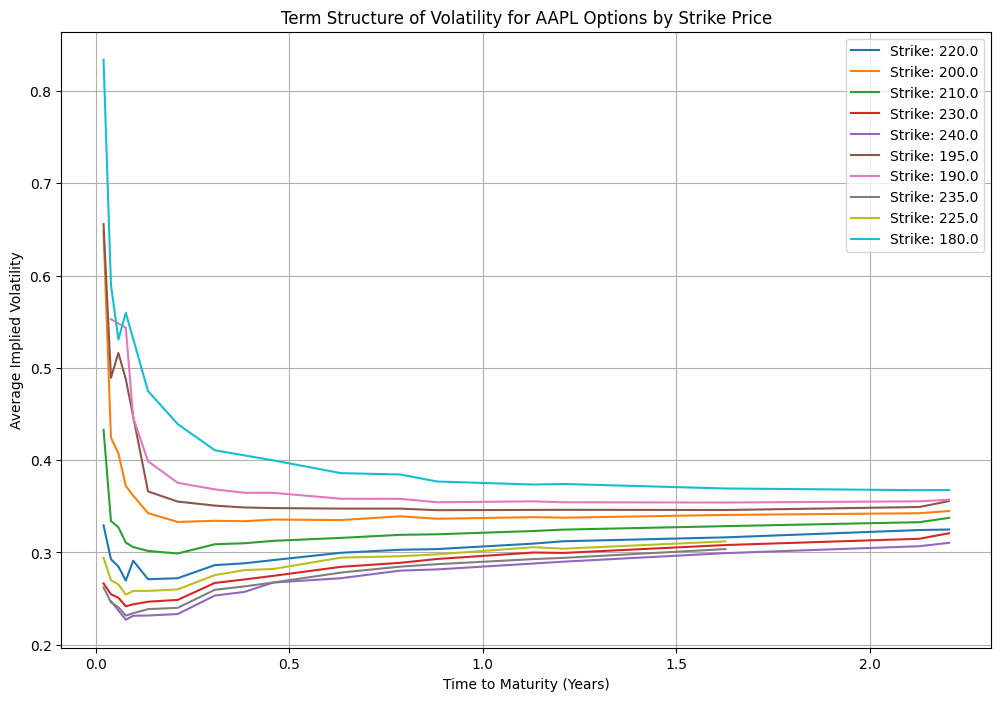

In [194]:

plt.figure(figsize=(12, 8))
strike_prices = options_data['strike'].value_counts().nlargest(10).index
for strike in strike_prices:
    strike_data = options_data[options_data['strike'] == strike]
    term_structure = strike_data.groupby('TTM')['impliedVolatility'].mean().reset_index()
    plt.plot(term_structure['TTM'], term_structure['impliedVolatility'], marker='', linestyle='-', label=f'Strike: {strike}')

plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Average Implied Volatility')
plt.title('Term Structure of Volatility for AAPL Options by Strike Price')
plt.legend()
plt.grid(True)
plt.show()

# 1.4 Volatility Surface

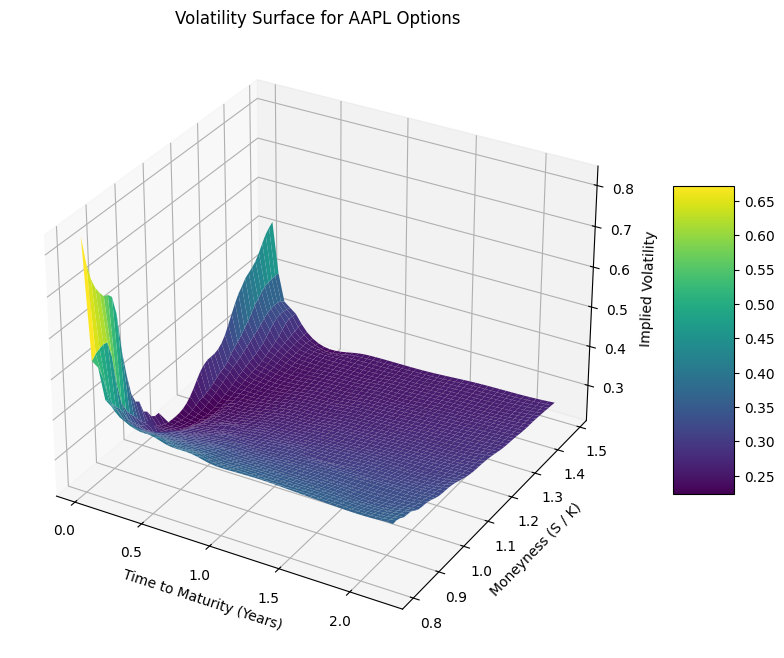

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Load options data for surface plot
surface_data = options_data

# Prepare grid data for interpolation
moneyness_range = np.linspace(surface_data['Moneyness'].min(), surface_data['Moneyness'].max(), 50)
ttm_range = np.linspace(surface_data['TTM'].min(), surface_data['TTM'].max(), 50)
moneyness_grid, ttm_grid = np.meshgrid(moneyness_range, ttm_range)

# Perform cubic interpolation for implied volatility
volatility_grid = griddata(
    (surface_data['Moneyness'], surface_data['TTM']),
    surface_data['impliedVolatility'],
    (moneyness_grid, ttm_grid),
    method='cubic'
)

# Plot the volatility surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Use plot_surface to draw a smooth surface
surf = ax.plot_surface(ttm_grid, moneyness_grid, volatility_grid, cmap='viridis', edgecolor='none')
ax.set_xlabel('Time to Maturity (Years)')
ax.set_ylabel('Moneyness (S / K)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for AAPL Options')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()


# Q2 GARCH Simulation

In [225]:
import numpy as np

# GARCH(1,1) parameters
a = garch_result.params['omega']
b = garch_result.params['alpha[1]']
c = garch_result.params['beta[1]']
mu = garch_result.params['mu']  # Mean return under the physical measure

# Simulation settings
S0 = 222.91  # Initial asset price
K = 230     # Strike price
Maturity_date = pd.to_datetime('2024-11-8')
today = pd.to_datetime('2024-11-01')
Period = (Maturity_date - today).days
T = Period / 365  # Time to maturity (in years)
r = 0.05     # Risk-free rate
n_simulations = 10000
n_steps = 100
dt = T / n_steps

# Initialize arrays
price_paths = np.zeros((n_simulations, n_steps + 1))
price_paths[:, 0] = S0

vol_paths = np.zeros((n_simulations, n_steps + 1))
vol_paths[:, 0] = garch_result.conditional_volatility.iloc[-1]

y_i = np.zeros((n_simulations, n_steps + 1))  # Residuals

for t in range(n_steps):
    Z = np.random.normal(size=n_simulations)  # Random shocks

    # Simulate asset prices using current volatility
    vol = vol_paths[:, t]
    price_paths[:, t+1] = price_paths[:, t] * np.exp(
        (mu - 0.5 * vol ** 2) * dt + vol * np.sqrt(dt) * Z
    )

    # Calculate standardized residual y_i
    log_return = np.log(price_paths[:, t+1]) - np.log(price_paths[:, t])
    y_i[:, t+1] = (log_return - (mu - 0.5 * vol ** 2) * dt) / np.sqrt(dt)

    # Update volatility based on GARCH(1,1)
    vol_paths[:, t+1] = np.sqrt(
        a + b * y_i[:, t+1] ** 2 + c * vol ** 2
    )

# Calculate option payoff
final_prices = price_paths[:, -1]
payoffs = np.maximum(final_prices - K, 0)

# Discount payoffs to present value
option_price = np.exp(-r * T) * np.mean(payoffs)

print(f"The estimated European call option for strike price = {K} price at Maturity Date = {Maturity_date}  is: {option_price:.2f}")


The estimated European call option for strike price = 230 price at Maturity Date = 2024-11-08 00:00:00  is: 0.75
